KERAS: RNN curves

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

random_seed = 42

2026-02-12 11:22:30.673611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770895351.688466    3403 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770895351.968732    3403 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770895354.544108    3403 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770895354.544138    3403 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770895354.544140    3403 computation_placer.cc:177] computation placer alr

In [2]:
# Make a File_Helper for saving and loading files.

save_files = True

import os
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras.models import load_model

class File_Helper:

	"""
	These routines let us conveniently save and load input data, such
	as text and image files, as well as save and load Keras model files
	and weight files.  When we save a file, the corresponding directory 
	is created if necessary. 
	
	When we make the object, we can optionally set the one argument really_save_files
	to True or False, depending on whether or not we want save_xx() calls to really
	write files. It's time-saving to set this to False when debugging because writing
	files can take a while. The default value is True.
	
	Here's a typical way to import this package from a file in a folder two levels down
	(adapted from https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
	
	# find the absolute path to the parent folder and add that to Python's search list
	import os, sys, inspect
	current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
	sys.path.insert(0, os.path.dirname(current_dir)) # path to grandparent dir
	# Now that we can find the folder, import the package and instantiate a File_Helper object
	from Python_Utilities import File_Helper
	file_helper = File_Helper(True)  
	"""
	
	def __init__(self, really_save_files=True):
		self.really_save_files = really_save_files
		self.saved_output_dir = 'saved_output'
		self.input_data_dir = 'input_data'
		self.saved_models_dir = 'saved_models'
		self.saved_weights_dir = 'saved_weights'

	def get_input_file_path(self, filename):
		"""Get the local path relative to the calling file's location to the input file"""
		return self.input_data_dir + '/' + filename
	
	def check_for_directory(self, directory, create_if_needed=True):
		"""See if the directory exists. Optionally, create it."""
		path_exists = os.path.exists(directory)
		if path_exists:
			if not os.path.isdir(directory):
				raise Exception('Found '+directory+' but it is a file, not a directory')
				return False
			return True
		if create_if_needed:
			os.makedirs(directory)
		return path_exists

	def save_figure(self, filename):
		"""Save the figure. Call this just before plt.show()."""
		if self.really_save_files and (filename != None):
			self.check_for_directory(self.saved_output_dir)
			plt.savefig(self.saved_output_dir+'/'+filename+'.png', dpi=300, bbox_inches='tight')

	def load_model_weights(self, model, weights_filename):
		"""If the weights file exists, load from it and return True, else return False."""
		fullpath = self.saved_weights_dir+'/'+weights_filename+'.h5'
		if os.path.exists(fullpath):
			if os.path.isfile(fullpath):
				model.load_weights(fullpath)
				return True
		return False

	def save_model_weights(self, model, weights_filename):
		"""Save the weights file in the saved weights directory."""
		if self.really_save_files and (weights_filename != None):
			self.check_for_directory(self.saved_weights_dir)
			fullpath = self.saved_weights_dir+'/'+weights_filename+'.h5'
			model.save_weights(fullpath)

	def load_model(self, model_filename):
		"""If the model file exists, load from it and return the model, else return None."""
		fullpath = self.saved_models_dir+'/'+model_filename+'.h5'
		if os.path.exists(fullpath):
			if os.path.isfile(fullpath):
				model = load_model(fullpath)
				return model
		return None

	def save_model(self, model, model_filename):
		"""Save the model file in the saved models directory."""
		if self.really_save_files and (model_filename != None):
			self.check_for_directory(self.saved_models_dir)
			fullpath = self.saved_models_dir+'/'+model_filename+'.h5'
			model.save(fullpath)

	def get_saved_output_dir(self):
		"""Get the name of the directory where we save matplotlib output PNG files."""
		return self.saved_output_dir
	
	def get_input_data_dir(self):
		"""Get the name of the directory where we look for input files."""
		return self.input_data_dir
	
	def get_saved_weights_dir(self):
		"""Get the name of the directory where we read and write Keras weight files."""
		return self.saved_weights_dir
	
	def get_saved_models_dir(self):
		"""Get the name of the directory where we read and write Keras model files."""
		return self.saved_models_dir
	
file_helper = File_Helper(save_files)

In [3]:
def sum_of_sines(number_of_steps, d_theta, skip_steps, freqs, amps, phases):
    '''Add together multiple sine waves and return a list of values that is
    number_of_steps long. d_theta is the step (in radians) between samples.
    skip_steps determines the start of the sequence. The lists freqs, amps,
    and phases should all the same length (but we don't check!)'''
    values = []
    for step_num in range(number_of_steps):
        angle = d_theta * (step_num + skip_steps)
        sum = 0
        for wave in range(len(freqs)):
            y = amps[wave] * math.sin(freqs[wave]*(phases[wave] + angle))
            sum += y
        values.append(sum)
    return np.array(values)

In [4]:
def sum_of_upsloping_sines(number_of_steps, d_theta, skip_steps, freqs, amps, phases):
    '''Like sum_of_sines(), but always sloping upwards'''
    np.random.seed(42)
    values = []
    for step_num in range(number_of_steps):
        angle = d_theta * (step_num + skip_steps)
        sum = 0
        for wave in range(len(freqs)):
            y = amps[wave] * math.sin(freqs[wave]*(phases[wave] + angle))
            sum += y
        values.append(sum)
        if step_num > 0:
            sum_change = sum - prev_sum
            if sum_change < 0:
                values[-1] *= -1
                if step_num == 1:
                    values[-2] *= -1
        prev_sum = sum
    return np.array(values)

In [5]:
def samples_and_targets_from_sequence(sequence, window_size):
    '''Return lists of samples and targets built from overlapping
    windows of the given size. Windows start at the beginning of 
    the input sequence and move right by 1 element.'''
    samples = []
    targets = []
    for i in range(sequence.shape[0]-window_size):
        sample = sequence[i:i+window_size]
        target = sequence[i+window_size]
        samples.append(sample)
        targets.append(target[0]) 
    return (np.array(samples), np.array(targets))

In [6]:
def make_data(data_sequence_number, training_length):
    training_sequence = test_sequence = []
    test_length = 200
    theta_step = .057
    if data_sequence_number == 0:
        freqs_list = [1, 2]
        amps_list = [1, 2]
        phases_list = [0, 0]
        data_maker = sum_of_sines
    elif data_sequence_number == 1:
        freqs_list = [1.1, 1.7, 3.1, 7]
        amps_list = [1,2,2,3]
        phases_list = [0,0,0,0]
        data_maker = sum_of_sines
    elif data_sequence_number == 2:
        freqs_list = [1.1, 1.7, 3.1, 7]
        amps_list = [1,2,2,3]
        phases_list = [0,0,0,0]
        data_maker = sum_of_upsloping_sines
    else:
        print("***** ERROR! Unknown data_sequence_number = ",data_sequence_number)
    training_sequence = data_maker(training_length, theta_step, 0, freqs_list, amps_list, phases_list)
    test_sequence = data_maker(test_length, theta_step, 2*training_length, freqs_list, amps_list, phases_list)
    return (training_sequence, test_sequence)

In [7]:
def show_data_sets(training_length):
    for i in range(0, 3):
        (training_sequence, test_sequence) = make_data(i, training_length)
        plt.figure(figsize=(8,3))
        
        plt.subplot(1, 2, 1)
        plt.plot(training_sequence)
        plt.title('training sequence, set '+str(i))
        plt.xlabel('index')
        plt.ylabel('value')
        
        plt.subplot(1, 2, 2)
        plt.plot(test_sequence)
        plt.title('test sequence, set '+str(i))
        plt.xlabel('index')
        plt.ylabel('value')
        
        plt.tight_layout()
        file_helper.save_figure('RNN-data-set-'+str(i))
        plt.show()

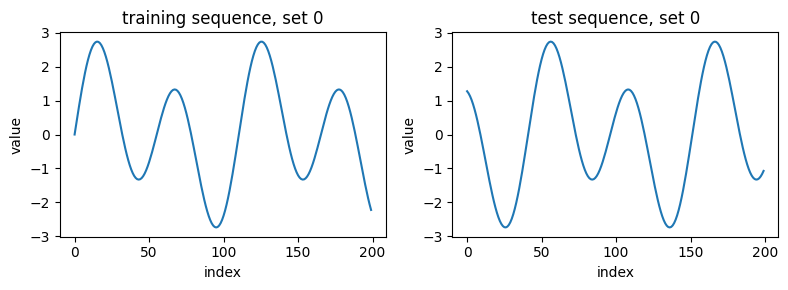

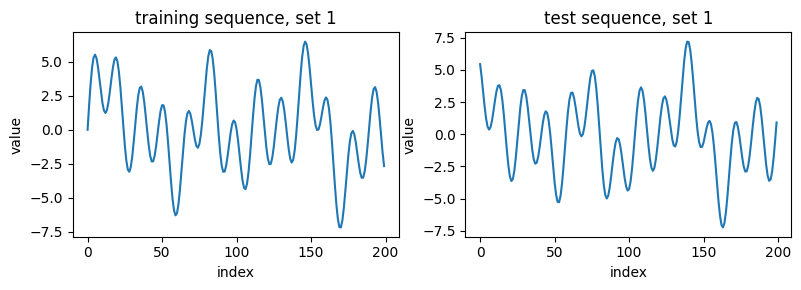

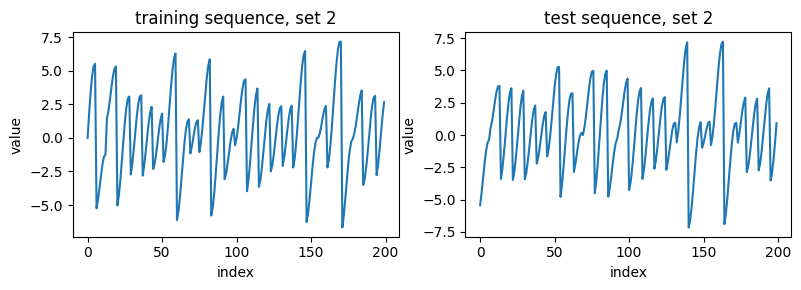

In [8]:
show_data_sets(training_length=200)

In [9]:
def scale_sequences(training_sequence, test_sequence):
    # reshape train and test sequences to form needed by MinMaxScaler
    training_sequence = np.reshape(training_sequence, (training_sequence.shape[0], 1))
    test_sequence = np.reshape(test_sequence, (test_sequence.shape[0], 1))
    Min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    Min_max_scaler.fit(training_sequence)
    scaled_training_sequence = Min_max_scaler.transform(training_sequence)
    scaled_test_sequence = Min_max_scaler.transform(test_sequence)
    return (Min_max_scaler, scaled_training_sequence, scaled_test_sequence)

In [10]:
# chop up train and test sequences into overlapping windows of the given size
def chop_up_sequences(training_sequence, test_sequence, window_size):
    (X_train, y_train) = samples_and_targets_from_sequence(training_sequence, window_size)
    (X_test, y_test) = samples_and_targets_from_sequence(test_sequence, window_size)
    return (X_train, y_train, X_test, y_test)

In [11]:
def make_data_set(data_sequence_number, window_size, training_length):
    (training_sequence, test_sequence) = make_data(data_sequence_number, training_length)
    (Min_max_scaler, scaled_training_sequence, scaled_test_sequence) = \
            scale_sequences(training_sequence, test_sequence)
    (X_train, y_train, X_test, y_test)= chop_up_sequences(scaled_training_sequence, scaled_test_sequence, window_size)
    return (Min_max_scaler, X_train, y_train, X_test, y_test, training_sequence, test_sequence)

In [12]:
# build and run the first model. 
def make_model(model_number, window_size):
    model = Sequential()
    if model_number == 0:
        model.add(LSTM(3, input_shape=[window_size, 1]))
        model.add(Dense(1, activation=None))
    elif model_number == 1:
        model.add(LSTM(3, return_sequences=True, input_shape=[window_size, 1]))
        model.add(LSTM(3))
        model.add(Dense(1, activation=None))
    elif model_number == 2:
        model.add(LSTM(9, return_sequences=True, input_shape=[window_size, 1]))
        model.add(LSTM(6, return_sequences=True))
        model.add(LSTM(3))
        model.add(Dense(1, activation=None))
    else:
        print("*** ERROR: make_model unknown model_number = ",model_number)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [13]:
def build_and_compare(model_number, data_set_number, window_size, training_length, epochs):
    np.random.seed(random_seed)
    model = make_model(model_number, window_size)
    (Min_max_scaler, X_train, y_train, X_test, y_test, training_sequence, test_sequence) = \
        make_data_set(data_set_number, window_size, training_length)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0)
    
    # Predict 
    y_train_predict = np.ravel(model.predict(X_train))
    y_test_predict = np.ravel(model.predict(X_test))
    
    # invert transformation
    inverse_y_train_predict = Min_max_scaler.inverse_transform([y_train_predict])
    inverse_y_test_predict = Min_max_scaler.inverse_transform([y_test_predict])    
    
    plot_string = '-dataset-'+str(data_set_number)+'-window-'+str(window_size)+\
                    '-model_number-'+str(model_number)+'-length-'+str(training_length)+'-epochs-'+str(epochs)
        
    plt.plot(history.history['loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss for data set '+str(data_set_number)+', window '+str(window_size))
    file_helper.save_figure('RNN-loss'+plot_string)
    plt.show()
    
    # plot training and predictions

    plt.plot(training_sequence, label="train", color='black', linewidth=2, zorder=20)
    skip_values = np.array(window_size*(np.nan,))
    flat_predict = np.ravel(inverse_y_train_predict)
    plot_predict = np.append(skip_values, flat_predict)
    plt.plot(plot_predict, label="train predict", color='red', linewidth=2, zorder=10)
    plt.legend(loc='best')
    plt.xlabel('index')
    plt.ylabel('train and prediction')
    plt.title('training set '+str(data_set_number)+', window '+str(window_size))    
    file_helper.save_figure('RNN-train-predictions'+plot_string)
    plt.show()
    
    plt.plot(test_sequence, label="test", color='black', linewidth=2, zorder=20)
    skip_values = np.array(window_size*(np.nan,))
    flat_predict = np.ravel(inverse_y_test_predict)
    plot_predict = np.append(skip_values, flat_predict)
    plt.plot(plot_predict, label="test predict", color='red', linewidth=2, zorder=10)
    plt.legend(loc='best')
    plt.xlabel('index')
    plt.ylabel('test and prediction')
    plt.title('test set '+str(data_set_number)+', window '+str(window_size))
    plt.tight_layout()
    file_helper.save_figure('RNN-test-predictions'+plot_string)
    plt.show()

### Slow Alert!

If you're running without a GPU (and maybe even if you are), the last two
of these runs will take a while. It might be hours, or even days. Plan ahead!


I0000 00:00:1770895477.890749    3403 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13775 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5
/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1770895483.000163    3788 cuda_dnn.cc:529] Loaded cuDNN version 90501


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


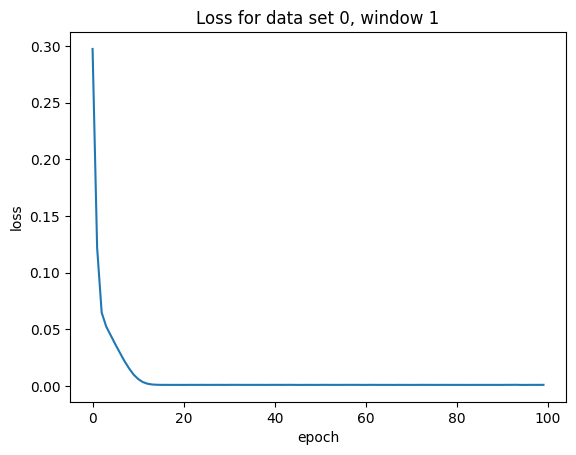

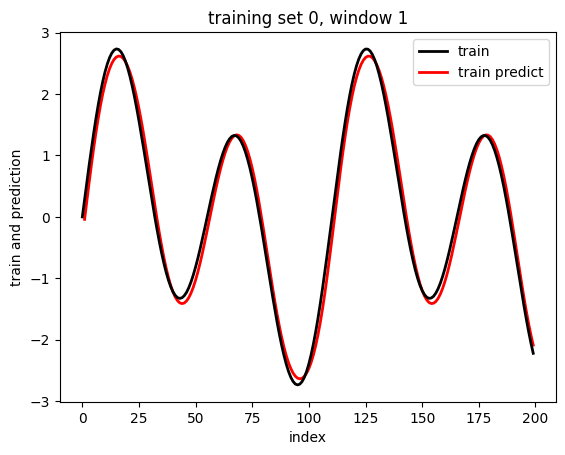

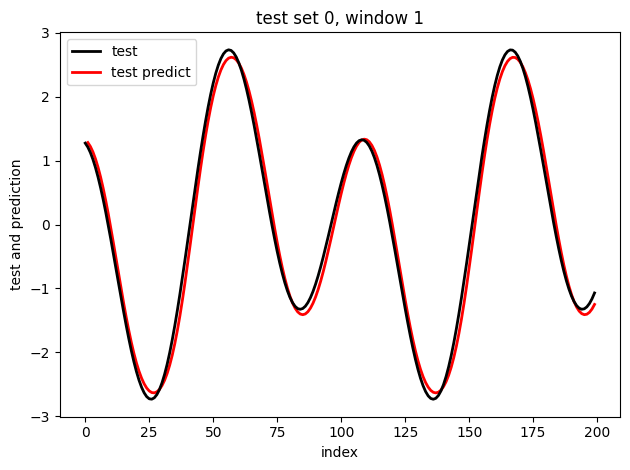

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


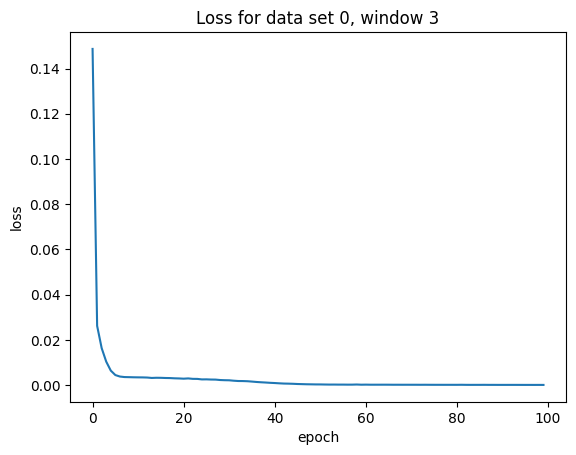

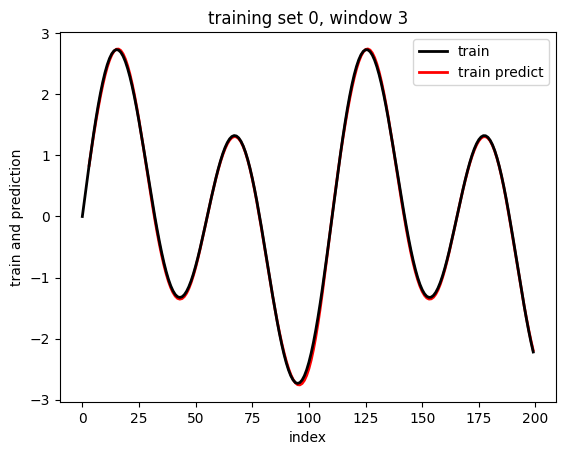

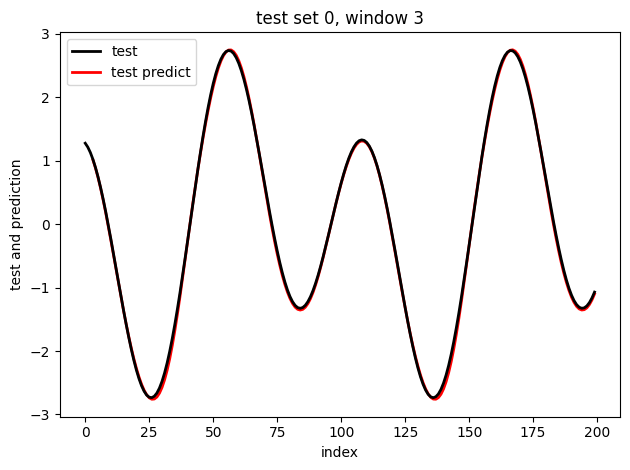

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


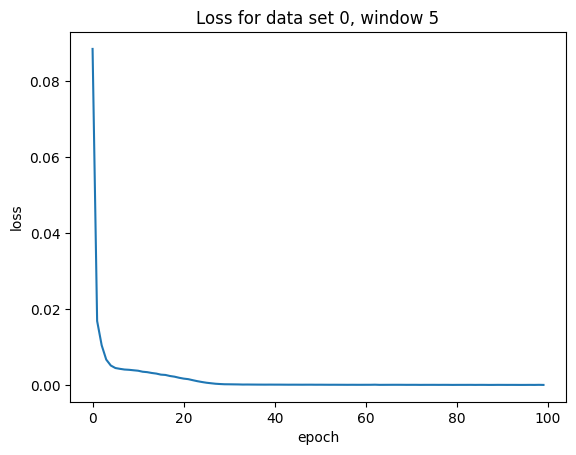

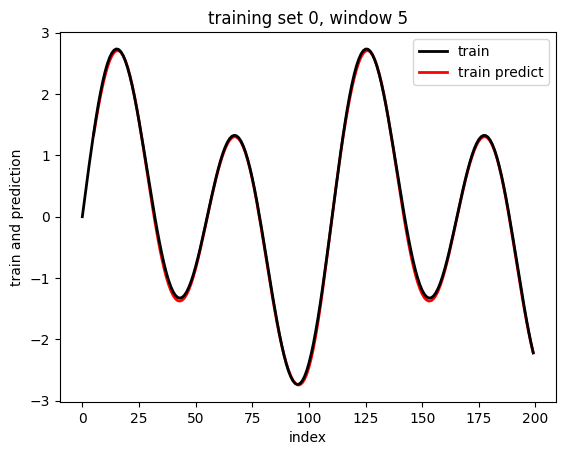

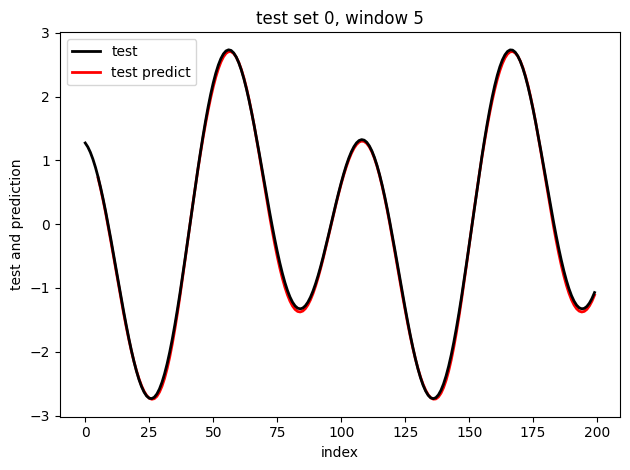

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


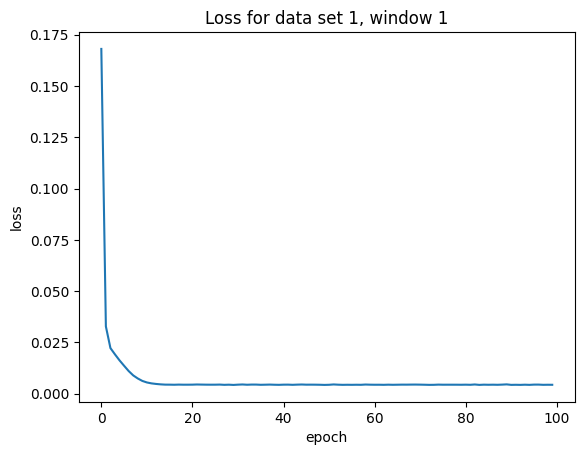

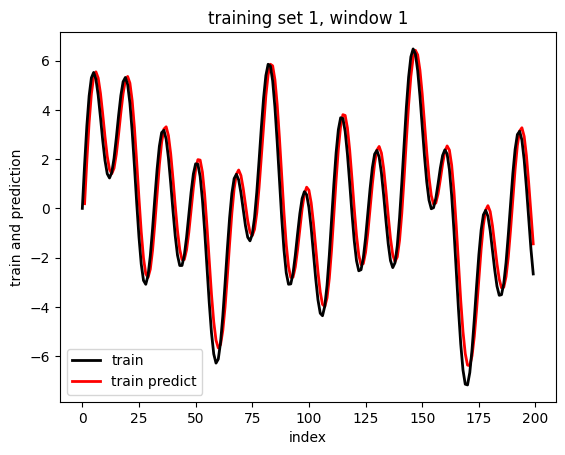

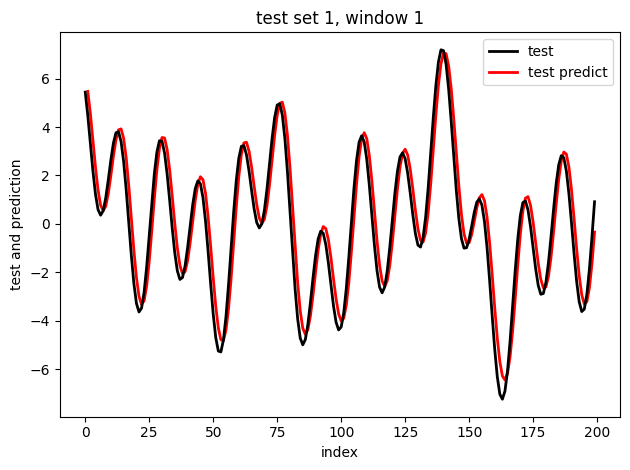

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


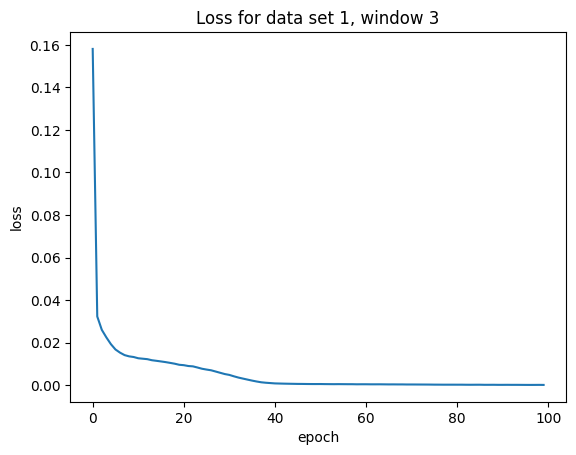

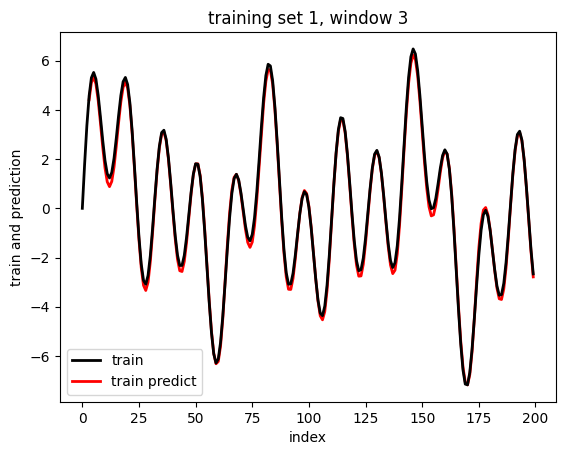

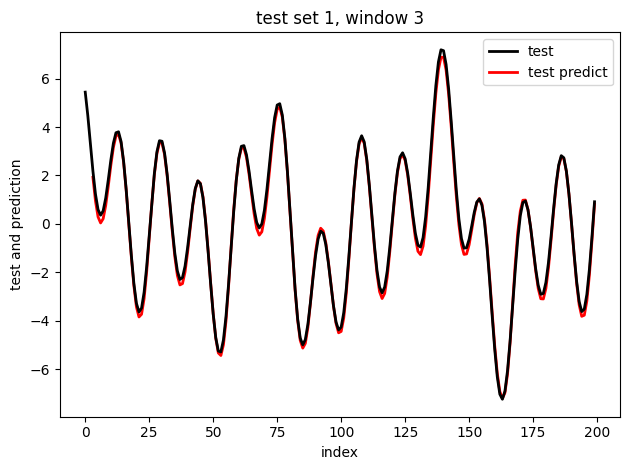

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


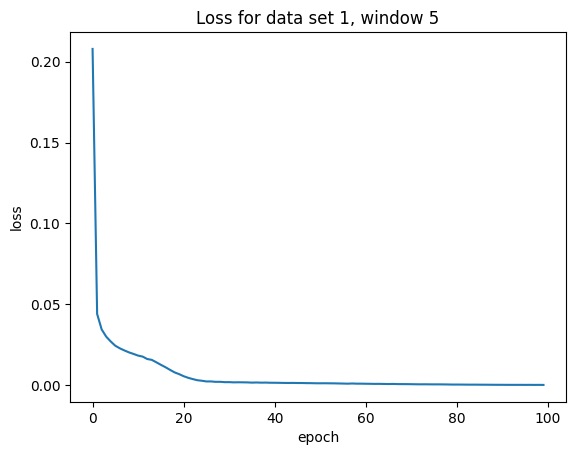

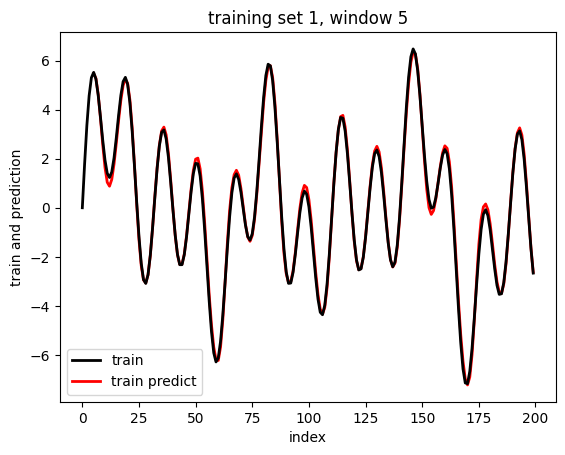

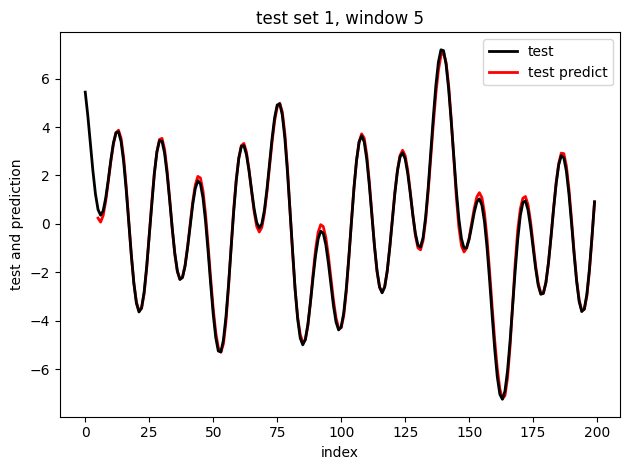

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


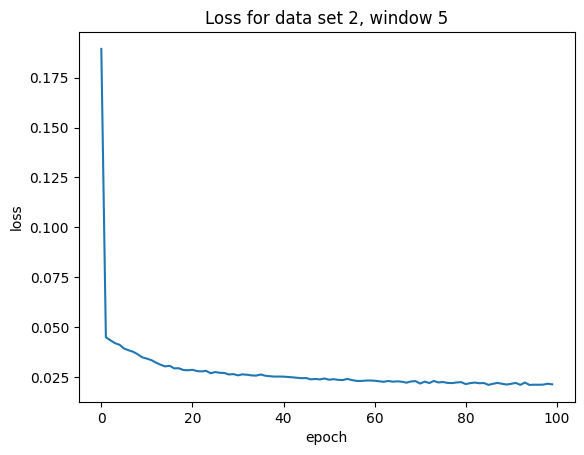

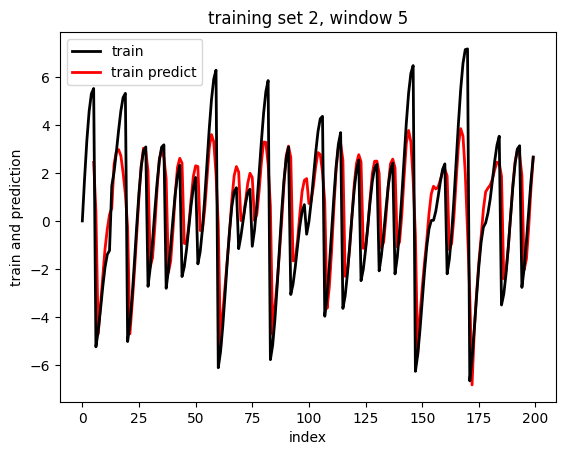

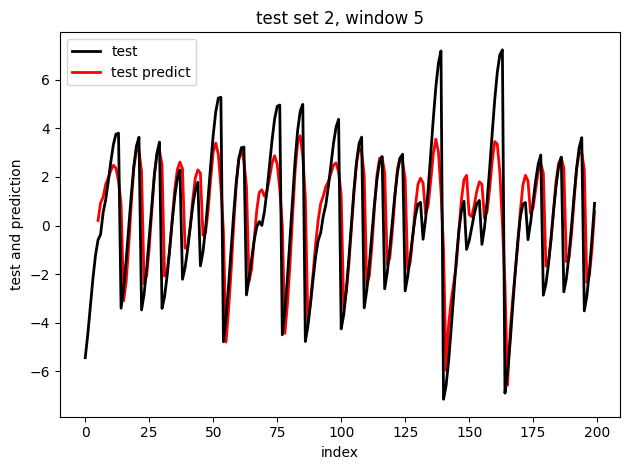

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


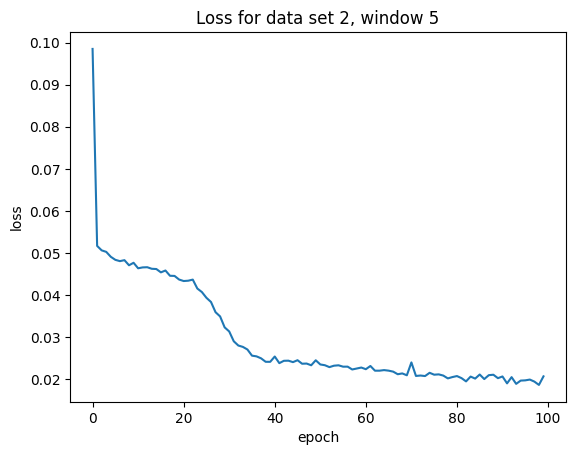

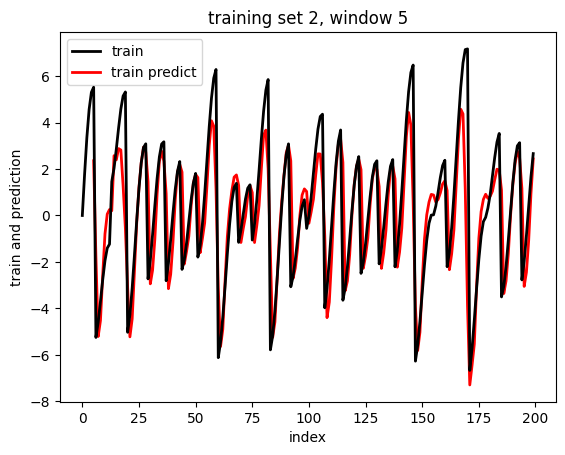

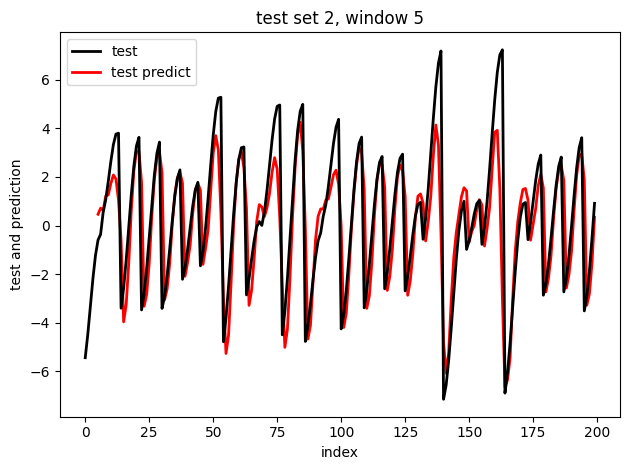

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


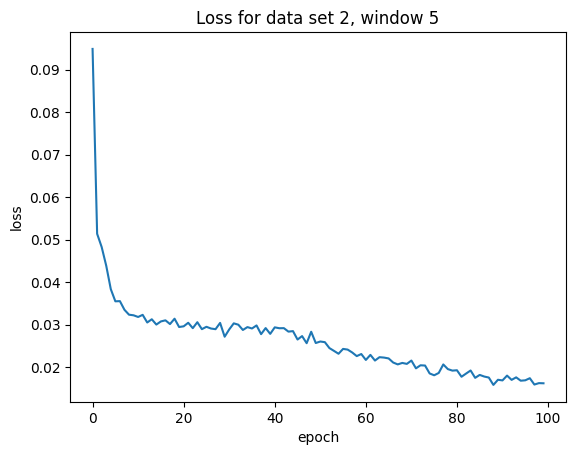

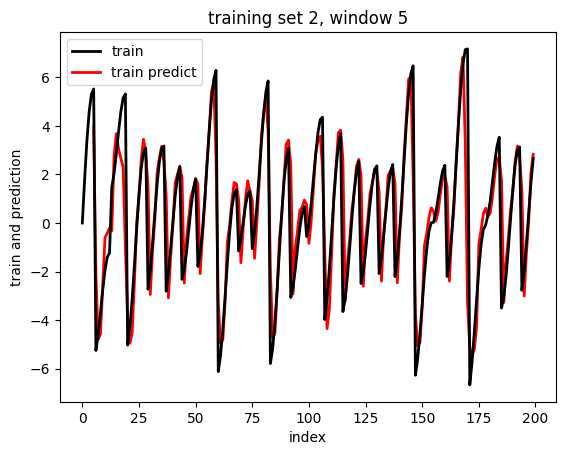

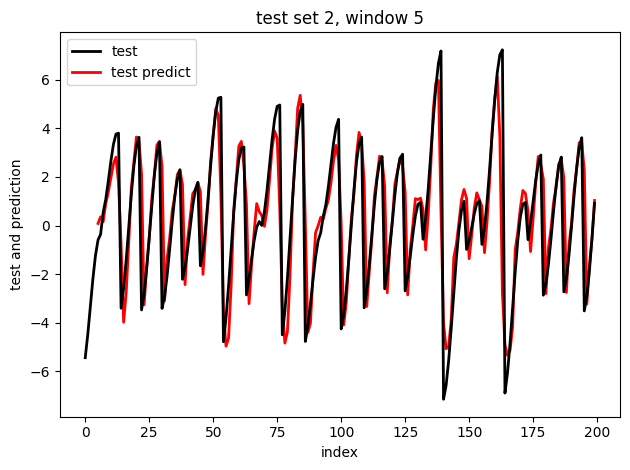

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


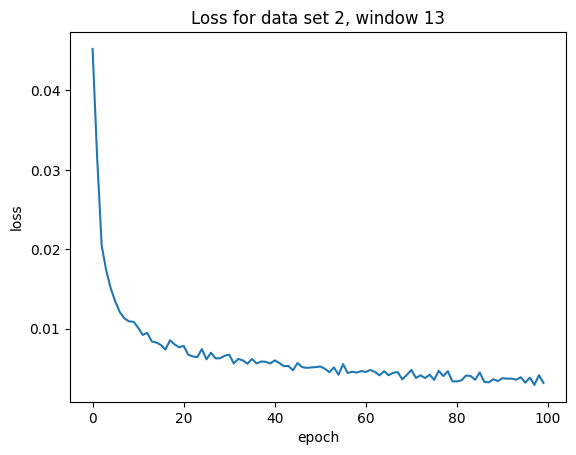

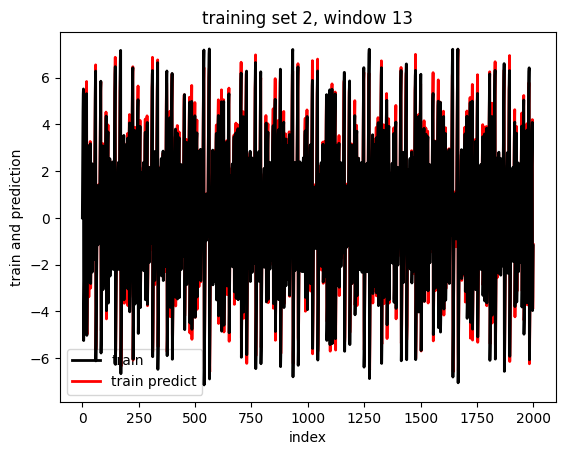

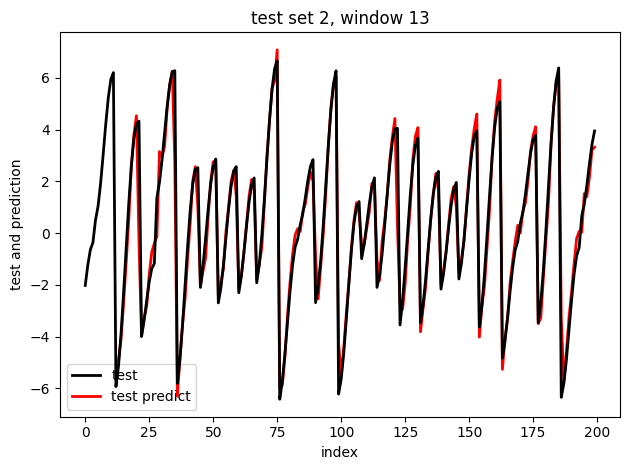

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


: 

: 

In [14]:
build_and_compare(model_number=0, data_set_number=0, window_size=1, training_length=200, epochs=100)
build_and_compare(model_number=0, data_set_number=0, window_size=3, training_length=200, epochs=100)
build_and_compare(model_number=0, data_set_number=0, window_size=5, training_length=200, epochs=100)

build_and_compare(model_number=0, data_set_number=1, window_size=1, training_length=200, epochs=100)
build_and_compare(model_number=0, data_set_number=1, window_size=3, training_length=200, epochs=100)
build_and_compare(model_number=0, data_set_number=1, window_size=5, training_length=200, epochs=100)

build_and_compare(model_number=0, data_set_number=2, window_size=5, training_length=200, epochs=100)

build_and_compare(model_number=1, data_set_number=2, window_size=5, training_length=200, epochs=100)

build_and_compare(model_number=2, data_set_number=2, window_size=5, training_length=200, epochs=100)
build_and_compare(model_number=2, data_set_number=2, window_size=13, training_length=2000, epochs=100)
build_and_compare(model_number=2, data_set_number=2, window_size=13, training_length=20000, epochs=100)